# Machine Learning Models: Decision Trees
On this page, we explore Decision Trees and showcase one of their use cases.

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

We'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/get-audio-features). 

## 1. Read and split the dataset
<hr>

- We use `read_csv` from the pandas package to read the data.  
- We use `train_test_split` from sklearn to split the data into separate training and test sets. (Not to be confused with validation sets which will be created later from the training set).  
  - The `test_size` parameter determines the proportion of the test set to the training set. Generally, a larger training set results in a better model, a larger test set results in a more accurate assessment of the model. We must find a balance between these two.
  - Note that the dataset is sorted on the target. If we maintain this list sorting our model will simply predict the target based on the song's position in the sorted list, rather than its features. This will not help us make predictions for future unseen data. Therefore, we set the first column as the index so that our model does not learn the sorted order of our data.

In [2]:
spotify_df = pd.read_csv("data/spotify.csv", index_col=0)

spotify_df.head() # to show a sample from the dataset

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.0102,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.1990,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.0344,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.6040,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.1800,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys


In [3]:
train_df = None
test_df = None

train_df, test_df = train_test_split(
    spotify_df, test_size=0.2, random_state=123
)

## 2. Exploratory Data Analysis (EDA)
In this section, we want to take a closer look at the dataset so that we can make more informed decisions when designing the model later.
<hr>

In [4]:
n_train_samples = train_df.shape[0]
n_test_samples = test_df.shape[0]

print(f"Number of training samples: {n_train_samples}")
print(f"Number of test samples: {n_test_samples}")


Number of training samples: 1613
Number of test samples: 404


In [5]:
spotify_summary = train_df.describe()
spotify_summary

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target
count,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000,1613.000000
mean,0.185627,0.616745,247114.827650,0.681296,0.136862,5.383137,0.189189,-7.112929,0.621203,0.091277,121.979777,3.964662,0.497587,0.507750
std,0.259324,0.163225,81177.300308,0.211612,0.277744,3.620422,0.153170,3.838867,0.485238,0.087890,26.965641,0.255201,0.247378,0.500095
min,0.000005,0.122000,16042.000000,0.014800,0.000000,0.000000,0.018800,-33.097000,0.000000,0.023100,47.859000,1.000000,0.035900,0.000000
25%,0.009190,0.511000,200105.000000,0.564000,0.000000,2.000000,0.092300,-8.388000,0.000000,0.037300,100.518000,4.000000,0.295000,0.000000
50%,0.062500,0.629000,230200.000000,0.714000,0.000071,6.000000,0.127000,-6.248000,1.000000,0.054900,121.990000,4.000000,0.496000,1.000000
75%,0.251000,0.738000,272533.000000,0.844000,0.057300,9.000000,0.243000,-4.791000,1.000000,0.107000,137.932000,4.000000,0.690000,1.000000
max,0.995000,0.984000,849960.000000,0.997000,0.976000,11.000000,0.969000,-0.307000,1.000000,0.816000,219.331000,5.000000,0.992000,1.000000


In the following plots, we explore different features and analyze their relationship with our target. 1 means the user liked the song, 0 means they did not.

Text(0.5, 0, 'loudness')

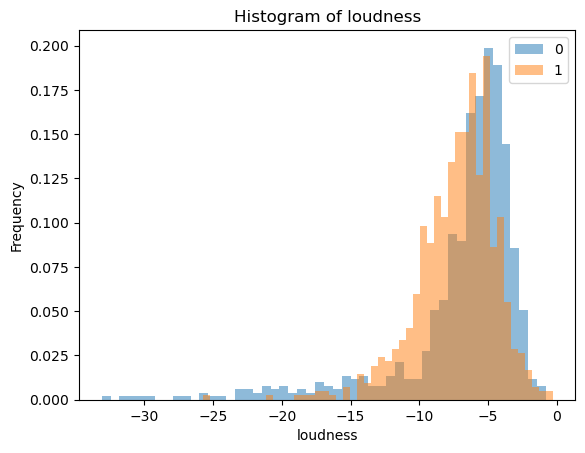

In [6]:
# Histogram for loudness
feat = "loudness"
train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat)
plt.xlabel(feat)

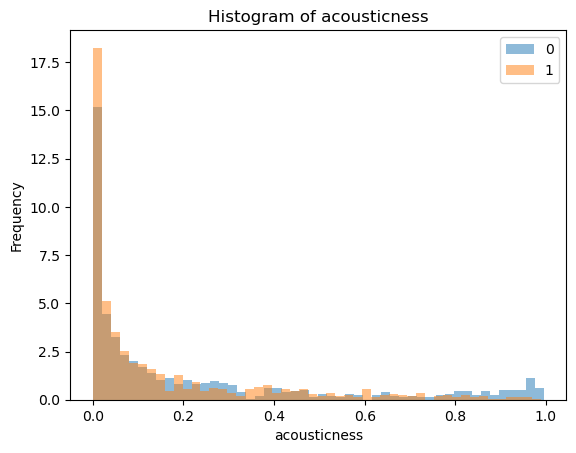

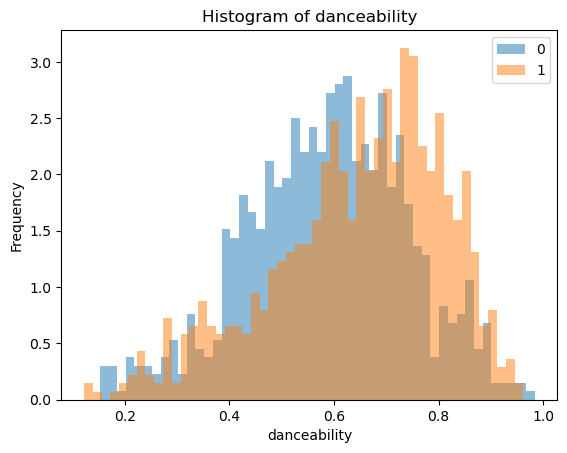

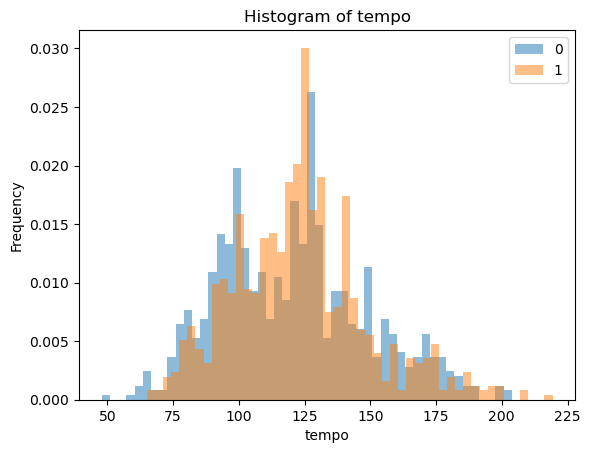

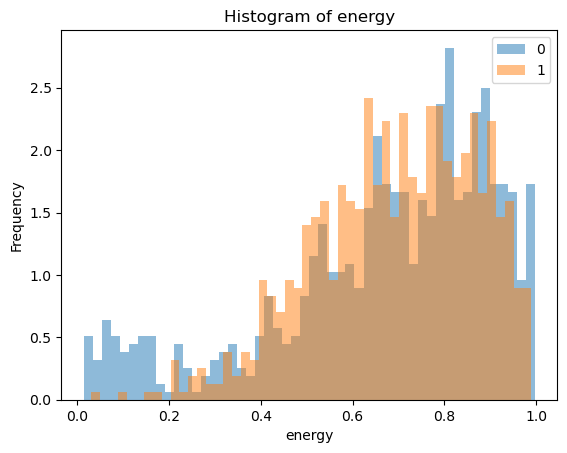

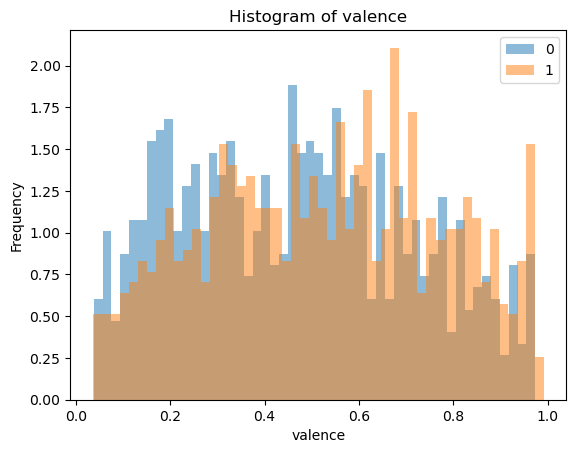

In [7]:
for feat in ['acousticness', 'danceability', 'tempo', 'energy', 'valence']: # This loop creates a histogram for each of the features in the list
    train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True, density = True, title = "Histogram of " + feat)
    plt.xlabel(feat)
    plt.show()

Keep in mind that even if we see a feature with a histogram that has not discernable patterns with the target, it does not necessarily mean that the feature is not useful for predicting the target. As some patterns only appear when a feature is combined with another. For example: Valence on its own seems insignificant for predicting the target, but that can change when we look at Valence alongside Tempo.

Note that the dataset includes two text features labeled `song_title` and `artist`. For now, we will simply drop these text features as encoding text can be tricky and may derail us from our original goal here, which is to explore decision trees.

## 3. Select features
<hr>

In this section, we select the features we want our model to learn. In our case, we will take all the available features except for `song_title` and `artist`. Note that we also need to split our x and y (features and target respectively).

In [8]:
X_train = train_df.drop(columns=['target', 'song_title', 'artist'])
y_train = train_df['target']
X_test = test_df.drop(columns=['target', 'song_title', 'artist'])
y_test = test_df['target']

## 4. Create and assess the baseline
<hr>

In this section, we create a very simple baseline model which we will use to measure our decision tree model against. In our case, the `DummyClassifier` will simply predict the most frequent case. Meaning if most songs in our dataset were liked, it will predict that they were all liked.  
We then use cross_val_score to assess our baseline model.

In [9]:
dum = DummyClassifier(random_state=123, strategy='most_frequent')
dummy_score = np.mean(cross_val_score(dum, X_train, y_train, cv=10))
dummy_score

np.float64(0.5077524729698643)

## 5. Create and assess the Decision Tree model
<hr>

In this section, we finally create the decision tree model, and we assess it using `cross_validate`. Note that this function fits the model to the dataset as its first step so we don't need to fit our model beforehand.

In [10]:
spotify_tree = DecisionTreeClassifier(random_state=123)

In [11]:
dt_scores_df = pd.DataFrame(cross_validate(spotify_tree, X_train, y_train, cv=10, return_train_score=True))
dt_scores_df


,fit_time,score_time,test_score,train_score
0,0.016004,0.002000,0.697531,0.999311
1,0.014143,0.002000,0.660494,1.000000
2,0.009999,0.001000,0.685185,0.999311
3,0.011000,0.001158,0.639752,1.000000
4,0.011091,0.002000,0.639752,0.999311
5,0.010095,0.002001,0.658385,0.999311
6,0.010088,0.001002,0.639752,0.999311
7,0.013002,0.001001,0.608696,0.999311
8,0.011600,0.002000,0.701863,0.999311
9,0.012999,0.001001,0.695652,0.999311


The main number we want to look at here is `test_score`. We ran 10 different tests on our model, let's take their mean value and compare it to our baseline.

In [12]:
round(dt_scores_df['test_score'].mean(), 3)

np.float64(0.663)

## 6. (Optional) Visualize the model
<hr>

In this section, we use the `tree` package to visualize our decision tree model to understand it better

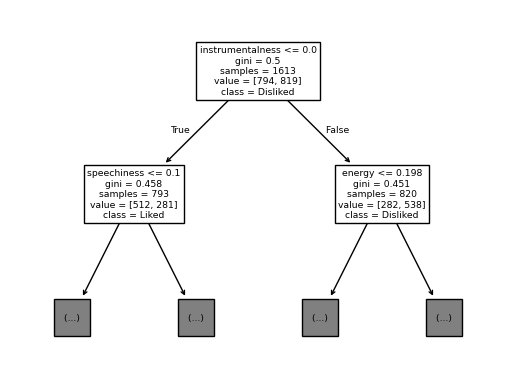

In [23]:
spotify_tree.fit(X_train, y_train) # We must fit (train) the model before we visualize it

feature_names = X_train.columns.tolist() # feature names 
class_names = ["Liked", "Disliked"] # unique class names 

toy_tree_viz = tree.plot_tree(spotify_tree, feature_names=feature_names, class_names=class_names, max_depth=1)
# The tree is too big and complicated to fully visualize, so we set max_depth=2 to visualize the first layers only

## 6. Hyperparameter optimization
<hr>

So far, we have used the decision tree model in its default configuration and got some decent results. But how can we make it perform better? We need to optimize its hyperparameters. In our case, the decision tree model has a single hyperparameter `depth` which determines the depths of the decision tree.  
Let's try out a number of different depths and see which one preforms best.

In [13]:
depths = np.arange(1, 25, 2)
depths

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])

In [14]:
results_dict = {
    "depth": [],
    "mean_train_score": [],
    "mean_cv_score": [],
}

for depth in depths: # Create a model for each depth in our list, assess it, and add it to our results_df
    model = DecisionTreeClassifier(max_depth=depth, random_state=123)
    scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_score"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_score"].append(np.mean(scores["train_score"]))

results_df = pd.DataFrame(results_dict)
results_df = results_df.set_index("depth")
results_df

,mean_train_score,mean_cv_score
depth,,
1,0.651030,0.646032
3,0.733485,0.692524
5,0.794035,0.711713
7,0.858718,0.703060
9,0.912930,0.690610
11,0.955157,0.680048
13,0.980850,0.674457
15,0.993525,0.658979
17,0.998278,0.669538


We can see that in our case, depth 5 yields the best result: `0.711713`. However, we must also consider the **fundamental tradeoff**. We want our model to have the highest test scores, but if its training score is too high it may suggest that it is overfitting on our particular dataset and will generalize poorly to future unseen data. To take a closer look at this, let's plot our model's scores and see how they change as depth changes.

<Axes: xlabel='depth'>

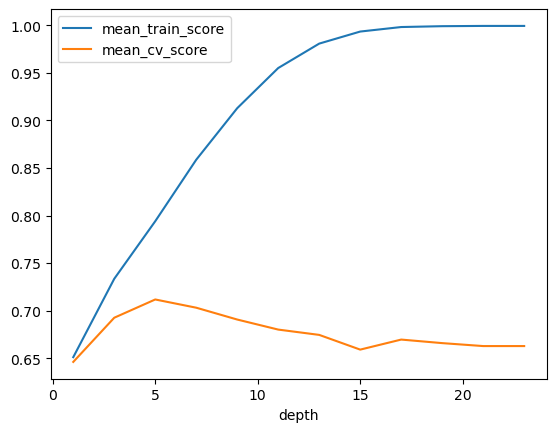

In [15]:
results_df[["mean_train_score", "mean_cv_score"]].plot()

<!-- END QUESTION -->

<br><br>

We can see that the `mean_cv_score` peaks at depth 5 then begins to decrease. Whereas the `mean_train_score` continuously increases. We can conclude that depth 5 is the ideal depth for our model in this use case. This is what we call "The sweet spot".

## 7. Final model and test
<hr>

In this section, we recreate our decision tree model using the optimized hyperparameter, then we test it and compare our results with out unoptimized and baseline models.

In [16]:
best_model = DecisionTreeClassifier(max_depth=5, random_state=123)
best_model.fit(X_test, y_test)
test_score = best_model.score(X_test, y_test)
test_score

0.8267326732673267

To recap:
- Baseline model score: ~0.51  
- Unoptimized decision tree model score: ~0.67  
- **Optimized decision tree model score**: ~0.83  